In [1]:
import numpy as np
import pandas as pd
# import geopandas as gpd
import matplotlib.pyplot as plt 
import json
%pylab inline 
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [2]:
!ls ../share/data/processed/

brand_info_food.csv	       poi_weekly_20211029.csv
cbg_attr_and_cluster_1009.csv  social_distancing_nyc.csv
cbg_attr_and_cluster_1021.csv  weekly_and_core.csv
cbg_distance_matrix.csv        weekly_and_core_with_area.csv
files			       weekly_brand_info.csv
home_weekly_20211029.csv       weekly_patterns_with_general_info.csv
placekey_and_area.csv	       weekly_trips_20211017.csv
poi_info.csv		       weekly_trips_by_cbg.csv


In [3]:
cluster_attr = pd.read_csv('/green-projects/project-usifood/workspace/share/data/processed/cbg_attr_and_cluster_1021.csv')
clusters = cluster_attr[['census_block_group', 'Cluster']].set_index('census_block_group')
clusters.head()

,Cluster
census_block_group,
360050001001,2
360050002001,2
360050002002,2
360050002003,3
360050004001,3


In [4]:
poi = pd.read_csv('/green-projects/project-usifood/workspace/share/data/processed/poi_info.csv')

In [180]:
other_retail = [
    'Beer, Wine, and Liquor Stores',
    'Big Box Grocers',
    'Delis and Convenience Stores',
    'Food Services',
    'General Merchandise Stores',
    #'Pharmacies and Drug Stores',
    'Specialty Food Stores',
    #'Supermarkets',
    'Tobacco Stores',
]

other_service = [
    'Drinking Places',
    #'Fast-Food Restaurants',
    #'Full-Service Restaurants',
    #'Limited-Service Restaurants',
    'Snack and Bakeries',
]

In [181]:
poi['combined_category'] = poi['category']
poi.loc[poi['category'].isin(other_retail), 'combined_category'] = 'Other Food Retail'
poi.loc[poi['category'].isin(other_service), 'combined_category'] = 'Other Food Service'

In [182]:
poi.columns

Index(['placekey', 'poi_cbg', 'category', 'location_name', 'latitude',
       'longitude', 'street_address', 'city', 'region', 'postal_code',
       'open_hours', 'safegraph_brand_ids', 'brands', 'top_category',
       'sub_category', 'naics_code', 'category_tags', 'opened_on', 'closed_on',
       'tracking_opened_since', 'tracking_closed_since', 'combined_category'],
      dtype='object')

In [184]:
categories = poi[['placekey', 'category', 'combined_category', 'poi_cbg']]
categories.head()

,placekey,category,combined_category,poi_cbg
0,222-222@627-s94-nwk,Specialty Food Stores,Other Food Retail,360470395002
1,223-222@627-rw6-zfz,Supermarkets,Supermarkets,360050386008
2,223-222@627-rwq-vcq,Supermarkets,Supermarkets,360050117001
3,223-222@627-sb5-8jv,Supermarkets,Supermarkets,360810107011
4,223-222@627-tkd-fvf,Supermarkets,Supermarkets,360811032021


In [197]:
trips = pd.read_csv('/green-projects/project-usifood/workspace/share/data/processed/home_weekly_20211029.csv')
trips = trips.merge(categories, on='placekey')
trips = trips.merge(clusters, left_on='home_cbg', right_on='census_block_group')
trips.head(3)

,placekey,date_range_start,home_cbg,visitor_count,estimated_visitor_count,pct_visitor_count,pct_estimated_visitor_count,cdi,category,combined_category,poi_cbg,Cluster
0,22t-222@627-s7m-rtv,2018-12-31 00:00:00-05:00,360470437004,4,9.974576,0.018433,0.018433,2.690041,Full-Service Restaurants,Full-Service Restaurants,360810635002,2
1,22t-222@627-s7m-rtv,2019-12-09 00:00:00-05:00,360470437004,4,13.299435,0.016667,0.016667,0.983968,Full-Service Restaurants,Full-Service Restaurants,360810635002,2
2,22t-222@627-s7m-rtv,2019-01-14 00:00:00-05:00,360470437004,4,8.274165,0.016667,0.016667,1.494221,Full-Service Restaurants,Full-Service Restaurants,360810635002,2


In [198]:
trips.date_range_start = pd.to_datetime(trips.date_range_start, utc=True)
trips['date'] = trips.date_range_start.dt.date
trips['year'] = trips.date_range_start.dt.year
trips['month'] = trips.date_range_start.dt.month

In [11]:
# set the figure and font size
import seaborn as sns 
sns.set(rc={'figure.figsize':(20, 8), "axes.titlesize":15, "axes.labelsize":12})

### POI Count by category

In [ ]:
# home POI Count

In [185]:
def get_count_and_pct_df(df, column_label):
    
    Count = df[['placekey', column_label, 'Cluster']].groupby(['Cluster', column_label]).count()
    Count = pd.pivot_table(Count, values='placekey', index=['Cluster'], columns=[column_label])
    
    Pct = Count.copy()
    for i in Pct.columns:
        Pct[i] = Pct[i]/Count.sum(axis=1)
    
    return Count, Pct

In [186]:
homepoi = categories.merge(clusters, left_on='poi_cbg', right_on='census_block_group')
poiCount, poiPct = get_count_and_pct_df(homepoi, 'combined_category')

In [187]:
poiCount

combined_category,Convenience Stores,Full-Service Restaurants,Limited-Service Restaurants,Other Food Retail,Other Food Service,Pharmacies and Drug Stores,Supermarkets
Cluster,,,,,,,
0,141,1313,455,318,657,405,415
1,412,5767,2275,1222,4315,941,812
2,177,1948,605,493,860,758,665
3,322,4257,1265,836,2253,1132,868


In [188]:
poiPct

combined_category,Convenience Stores,Full-Service Restaurants,Limited-Service Restaurants,Other Food Retail,Other Food Service,Pharmacies and Drug Stores,Supermarkets
Cluster,,,,,,,
0,0.038067,0.354482,0.122840,0.085853,0.177376,0.109341,0.112041
1,0.026169,0.366298,0.144499,0.077617,0.274073,0.059769,0.051575
2,0.032147,0.353796,0.109880,0.089539,0.156193,0.137668,0.120777
3,0.029452,0.389372,0.115705,0.076466,0.206073,0.103540,0.079393


In [193]:
def poi_plots(count_df, pct_df, which_type):
    
    fig, ax = plt.subplots(1,2,figsize=(20,5))

    cmap = plt.cm.get_cmap('tab20')
    colors = [cmap(i / 20) for i in range(0, 20)]

    count_df.plot.bar(color=colors, ax=ax[0])
    ax[0].set(xlabel='Clusters', ylabel='Number', title='%s POI Count' % which_type, xticks=count_df.index)
    ax[0].tick_params(axis='x', rotation=0)
    ax[0].get_legend().remove()

    for i in range(pct_df.shape[1]):
        if i == 0:
            ax[1].bar(pct_df.index, pct_df.iloc[:, i], width=0.75, color=colors[i], label=pct_df.columns[i], alpha=0.8)
        else:
            ax[1].bar(pct_df.index, pct_df.iloc[:, i], bottom=np.sum(pct_df.iloc[:, :i], axis=1), 
                      width=0.75, color=colors[i], label=pct_df.columns[i], alpha=0.8)
    ax[1].set(xlabel='Clusters', ylabel='Percentage', title='%s POI Category Composition' % which_type, xticks=pct_df.index)
    ax[1].legend(bbox_to_anchor=(0.45, -0.25, 0.1, 0.1), ncol=4, loc='lower center', 
                  bbox_transform=fig.transFigure, fontsize=15)

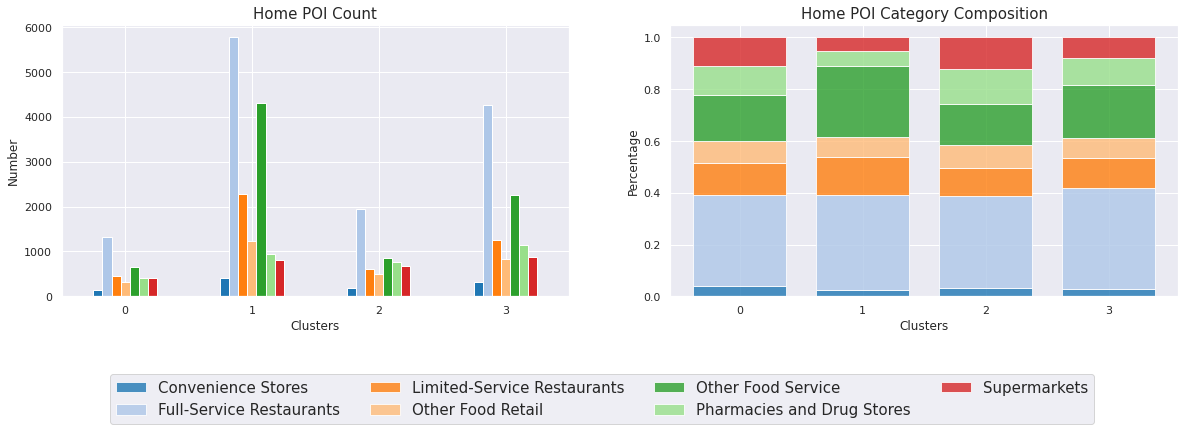

In [194]:
poi_plots(poiCount, poiPct, 'Home')

In [195]:
poiCount.sum(axis=1)

Cluster
0     3704
1    15744
2     5506
3    10933
dtype: int64

Text(0.5, 0, '')

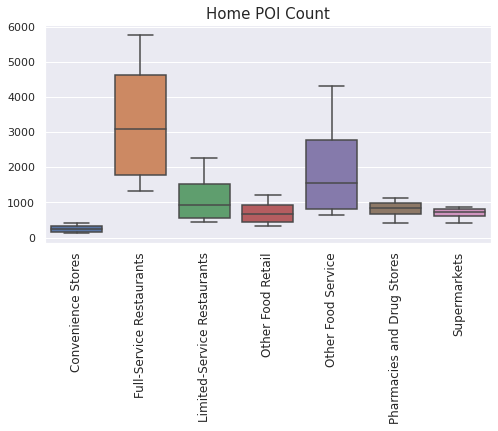

In [196]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=poiCount)
plt.xticks(fontsize=12, rotation=90)
plt.title('Home POI Count')
# plt.ylabel()
plt.xlabel(None)

In [ ]:
# Visited POI count by category

In [199]:
vstCount, vstPct = get_count_and_pct_df(trips, 'combined_category')

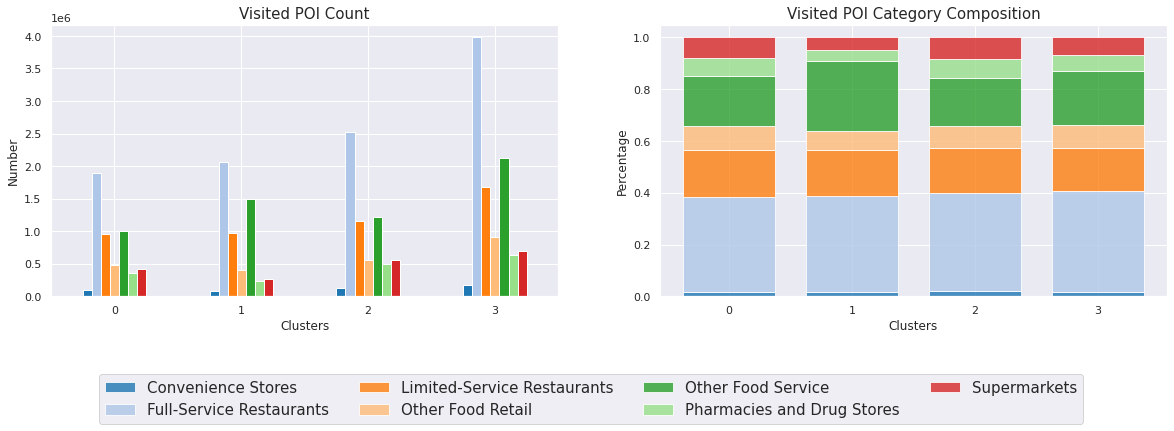

In [200]:
poi_plots(vstCount, vstPct, 'Visited')

In [201]:
vstCount.sum(axis=1)

Cluster
0     5211216
1     5510376
2     6634860
3    10192429
dtype: int64

Text(0.5, 0, '')

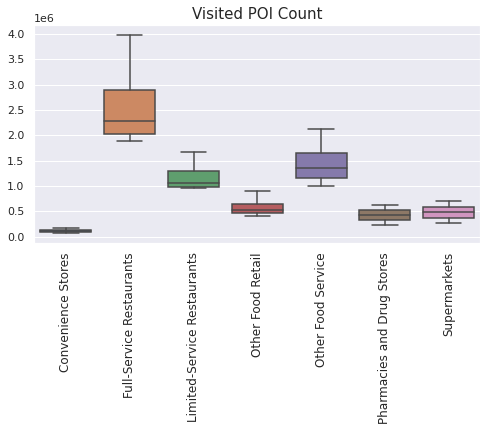

In [202]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=vstCount)
plt.xticks(fontsize=12, rotation=90)
plt.title('Visited POI Count')
# plt.ylabel()
plt.xlabel(None)

In [ ]:
# 2019 V.S. 2020 Visited (March-December) -- number decreased

In [203]:
trip2019 = trips[(trips.year==2019)&(trips.month>=3)]
trip2020 = trips[(trips.year==2020)&(trips.month>=3)]

In [204]:
vstCount19, vstPct19 = get_count_and_pct_df(trip2019, 'combined_category')
vstCount20, vstPct20 = get_count_and_pct_df(trip2020, 'combined_category')

In [ ]:
poi_plots(vstCount19, vstPct19, '2019 Visited')

In [ ]:
poi_plots(vstCount20, vstPct20, '2020 Visited')

In [205]:
vstCount19.sum(axis=1)

Cluster
0    2771320
1    3217905
2    3503897
3    5338335
dtype: int64

In [206]:
vstCount20.sum(axis=1)

Cluster
0    1265817
1    1068703
2    1623593
3    2560302
dtype: int64

In [207]:
changeCount = vstCount20-vstCount19
changePct = (vstCount20-vstCount19)/vstCount19

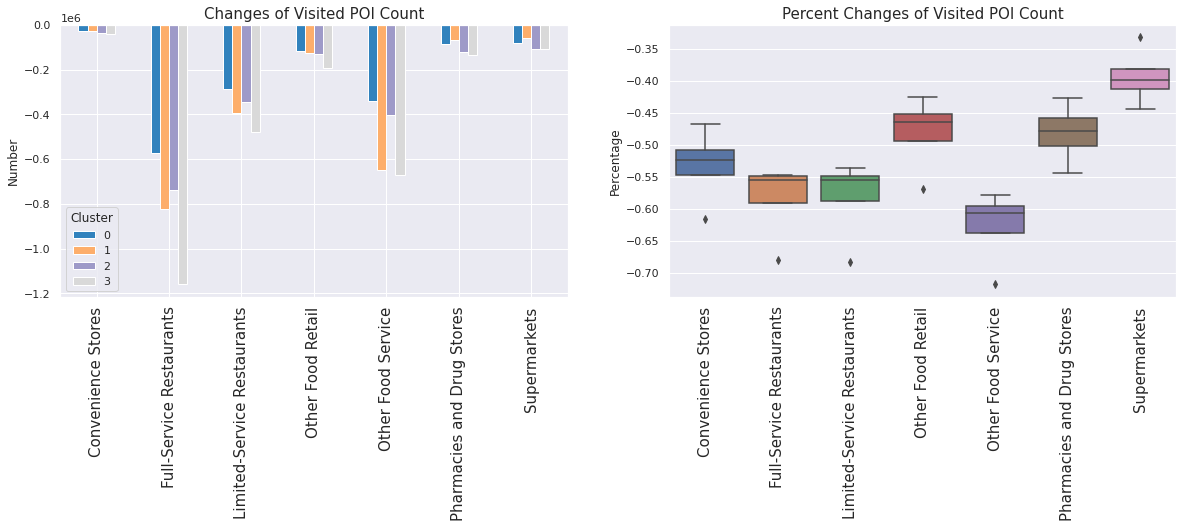

In [208]:
fig, ax = plt.subplots(1,2,figsize=(20,5))

changeCount.T.plot.bar(cmap='tab20c', ax=ax[0])
ax[0].set(xlabel=None, ylabel='Number', title='Changes of Visited POI Count')
ax[0].tick_params(axis='x', labelsize=15)

sns.boxplot(data=changePct, ax=ax[1])
ax[1].set(xlabel=None, ylabel='Percentage', title='Percent Changes of Visited POI Count')
ax[1].tick_params(axis='x', labelsize=15, rotation=90)

In [173]:
changePct

combined_category,Convenience Stores,Full-Service Restaurants,Limited-Service Restaurants,Other Food Retail,Other Food Service,Pharmacies and Drug Stores,Snack and Bakeries,Supermarkets
Cluster,,,,,,,,
0,-0.524844,-0.560198,-0.554738,-0.468269,-0.649354,-0.468906,-0.598057,-0.401055
1,-0.615494,-0.680207,-0.683907,-0.568673,-0.744572,-0.543258,-0.704196,-0.443734
2,-0.522253,-0.549980,-0.553582,-0.460998,-0.638153,-0.488422,-0.588196,-0.396823
3,-0.466731,-0.546676,-0.536832,-0.425529,-0.619272,-0.427325,-0.564099,-0.331438


### Estimated visitor count by category

In [209]:
def get_evc_pct_pivot_table(df, value_name, column_label):

    evc = df[['Cluster', column_label, value_name]].groupby(['Cluster', column_label], as_index=False).median()
    evc = pd.pivot_table(evc, values=value_name, index=['Cluster'], columns=[column_label])
    
    evcPct = evc.copy()
    for i in evcPct.columns:
        evcPct[i] = evcPct[i]/evc.sum(axis=1)

    return evc, evcPct

In [210]:
evc19, evcPct19 = get_evc_pct_pivot_table(trip2019, 'estimated_visitor_count', 'combined_category')
evc20, evcPct20 = get_evc_pct_pivot_table(trip2020, 'estimated_visitor_count', 'combined_category')

(array([0, 1, 2, 3]),
 [Text(0, 0, '0'), Text(1, 0, '1'), Text(2, 0, '2'), Text(3, 0, '3')])

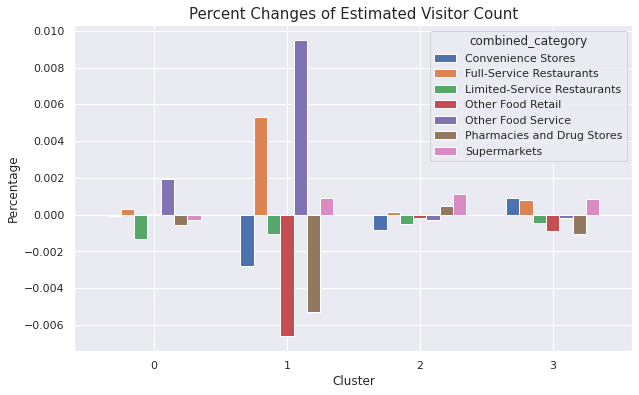

In [220]:
evcChg = evcPct20 - evcPct19
evcChg.plot.bar(figsize=(10,6), width=0.7)
plt.title('Percent Changes of Estimated Visitor Count')
plt.ylabel('Percentage')
plt.xticks(rotation=0)

In [212]:
_, evcPct19_ = get_evc_pct_pivot_table(trip2019, 'estimated_visitor_count', 'category')
_, evcPct20_ = get_evc_pct_pivot_table(trip2020, 'estimated_visitor_count', 'category')

<AxesSubplot:xlabel='Cluster'>

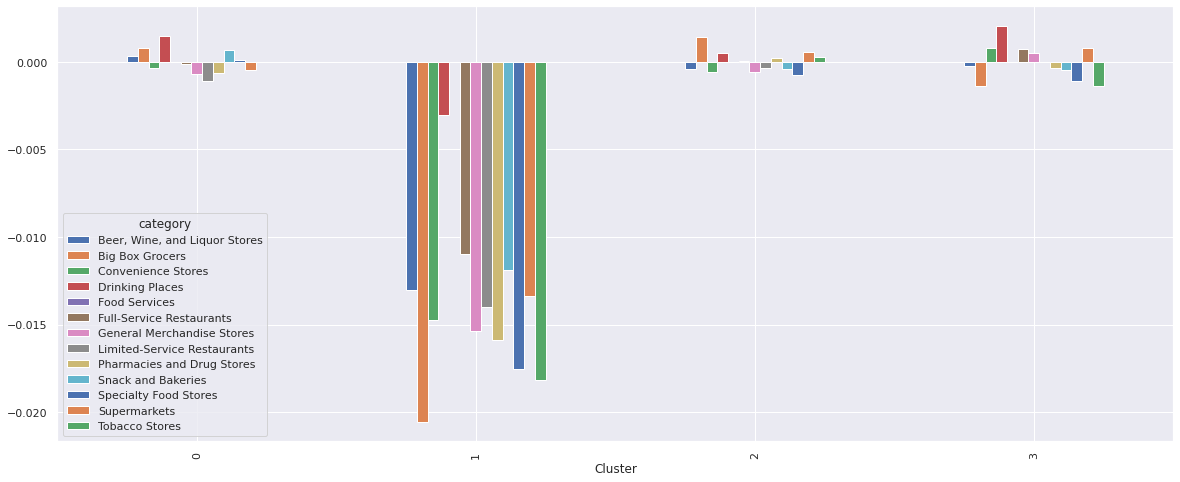

In [213]:
evcChg_ = evcPct20_ - evcPct19_
evcChg_.plot.bar()

### Time-series /Cluster /Category

In [224]:
tp19 = trip2019[['date', 'estimated_visitor_count', 'category', 'Cluster']]
tp19['date'] = pd.to_datetime(tp19['date'])
tp19['date'] = tp19['date'].dt.strftime('%m-%d')
tp19 = tp19.groupby(['category', 'Cluster', 'date'], as_index=False).median()
tp19 = pd.pivot_table(tp19, values='estimated_visitor_count', index=['date'], columns=['category', 'Cluster'])
tp19.head()

category Beer, Wine, and Liquor Stores                                 \
Cluster                              0          1         2         3   
date                                                                    
01-07                         7.211499  10.146965  7.395122  9.044872   
01-14                         7.577640  10.311301  7.234321  9.115282   
01-21                         7.692308  10.646918  7.788136  9.146865   
01-28                         7.627447  10.710526  7.645995  9.362346   
02-04                         7.827068  10.567063  7.858930  9.480000   

category Big Box Grocers                                Convenience Stores  \
Cluster                0          1         2         3                  0   
date                                                                         
01-07           7.548380  10.369287  7.382685  9.212698           7.267380   
01-14           7.521520  10.496261  7.543704  9.270045           7.137725   
01-21           7.770701  10.646918  7.672756  9.353666           7.231467   
01-28           7.763033  10.543974  7.868132  9.462963           7.573485   
02-04           7.944086  10.881226  7.852427  9.591398           7.611054   

category             ... Specialty Food Stores            \
Cluster           1  ...                     2         3   
date                 ...                                   
01-07     10.238095  ...              7.223970  8.888889   
01-14     10.498113  ...              7.420054  8.938330   
01-21     10.423913  ...              7.512821  9.048975   
01-28     10.389722  ...              7.720406  9.137558   
02-04     10.265714  ...              7.986262  9.252730   

category Supermarkets (except Convenience Stores)                       \
Cluster                                         0          1         2   
date                                                                     
01-07                                    7.299647  10.466886  7.445407   
01-14                                    7.352381  10.681223  7.507917   
01-21                                    7.482353  10.934169  7.575893   
01-28                                    7.749066  10.792554  7.959146   
02-04                                    7.861592  10.729858  7.852427   

category           Tobacco Stores                                 
Cluster          3              0          1         2         3  
date                                                              
01-07     9.186606       7.076412  10.252086  7.619195  8.869070  
01-14     9.297468       7.339088  10.171500  7.612233  9.044396  
01-21     9.426968       7.432679  10.472222  7.646051  8.953975  
01-28     9.526718       7.657798  10.891496  8.104080  9.182363  
02-04     9.624617       7.949886  10.873085  8.195718  8.838852  

[5 rows x 52 columns]

In [226]:
tp20 = trip2020[['date', 'estimated_visitor_count', 'category', 'Cluster']]
tp20['date'] = pd.to_datetime(tp20['date'])
tp20['date'] = tp20['date'].dt.strftime('%m-%d')
tp20 = tp20.groupby(['category', 'Cluster', 'date'], as_index=False).median()
tp20 = pd.pivot_table(tp20, values='estimated_visitor_count', index=['date'], columns=['category', 'Cluster'])
tp20.head()

category Beer, Wine, and Liquor Stores                                   \
Cluster                              0          1          2          3   
date                                                                      
01-06                        12.135231  13.449591  13.393382  11.182962   
01-13                        13.757252  15.719439  14.922861  12.065268   
01-20                        13.951893  15.350157  15.060606  12.315098   
01-27                        12.216216  14.603878  12.978495  11.389978   
02-03                        11.284091  13.027237  11.408829  10.583732   

category Big Box Grocers                                  Convenience Stores  \
Cluster                0          1          2          3                  0   
date                                                                           
01-06          12.386617  12.996016  13.433600  11.324397          11.779310   
01-13          13.757252  15.126685  14.393235  11.949606          13.108014   
01-20          14.020408  14.381793  14.604317  12.216949          13.470405   
01-27          12.474886  13.935813  13.085714  11.459873          11.890196   
02-03          11.284091  13.313953  11.630279  10.709381          11.022654   

category             ... Specialty Food Stores             \
Cluster           1  ...                     2          3   
date                 ...                                    
01-06     13.213720  ...             13.432990  11.190570   
01-13     15.748428  ...             15.031785  12.085349   
01-20     15.334476  ...             14.863813  12.089136   
01-27     14.677442  ...             13.367347  11.361894   
02-03     13.534884  ...             11.815603  10.265664   

category Supermarkets (except Convenience Stores)                        \
Cluster                                         0          1          2   
date                                                                      
01-06                                   12.479448  13.980612  13.706161   
01-13                                   13.546895  15.853861  15.137724   
01-20                                   13.776908  16.047510  15.492308   
01-27                                   12.201207  15.241935  13.342541   
02-03                                   11.352113  13.979716  11.687253   

category            Tobacco Stores                                   
Cluster           3              0          1          2          3  
date                                                                 
01-06     11.636364      11.972096  13.511209  13.739394  11.256281  
01-13     12.495114      13.611035  15.507042  15.740891  11.839599  
01-20     12.793177      13.241050  15.442177  15.066667  11.928889  
01-27     11.777778      12.187517  13.050634  13.313559  11.050847  
02-03     10.849095      11.317829  12.926179  11.819634  10.218430  

[5 rows x 52 columns]

In [175]:
len(tp19.category.unique())

13

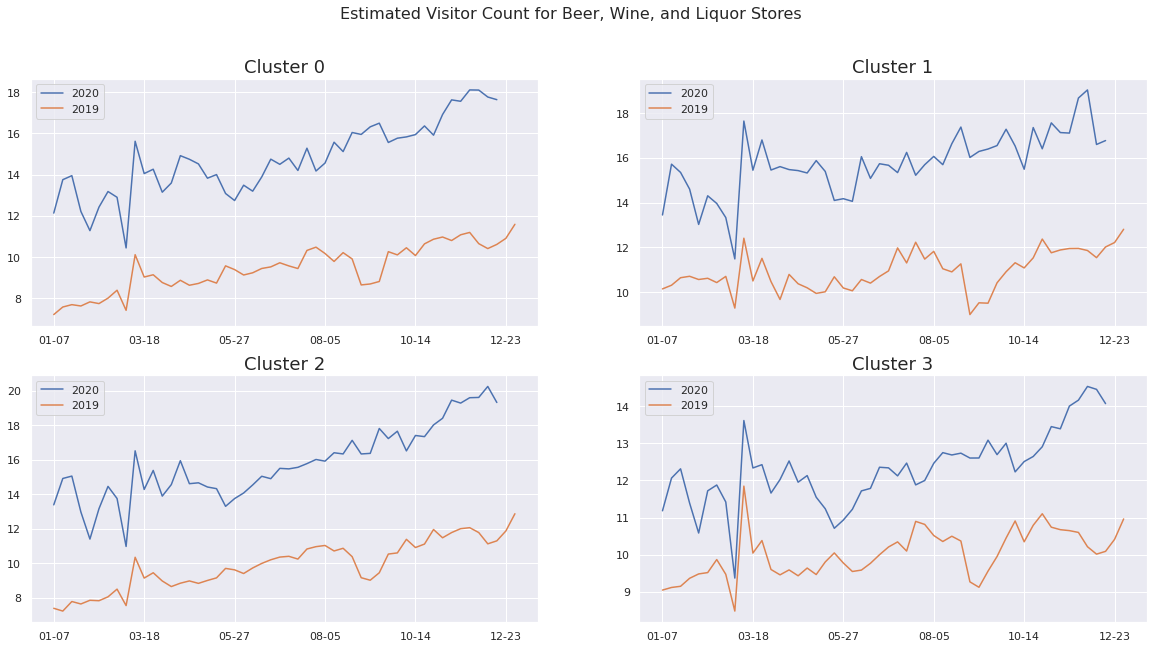

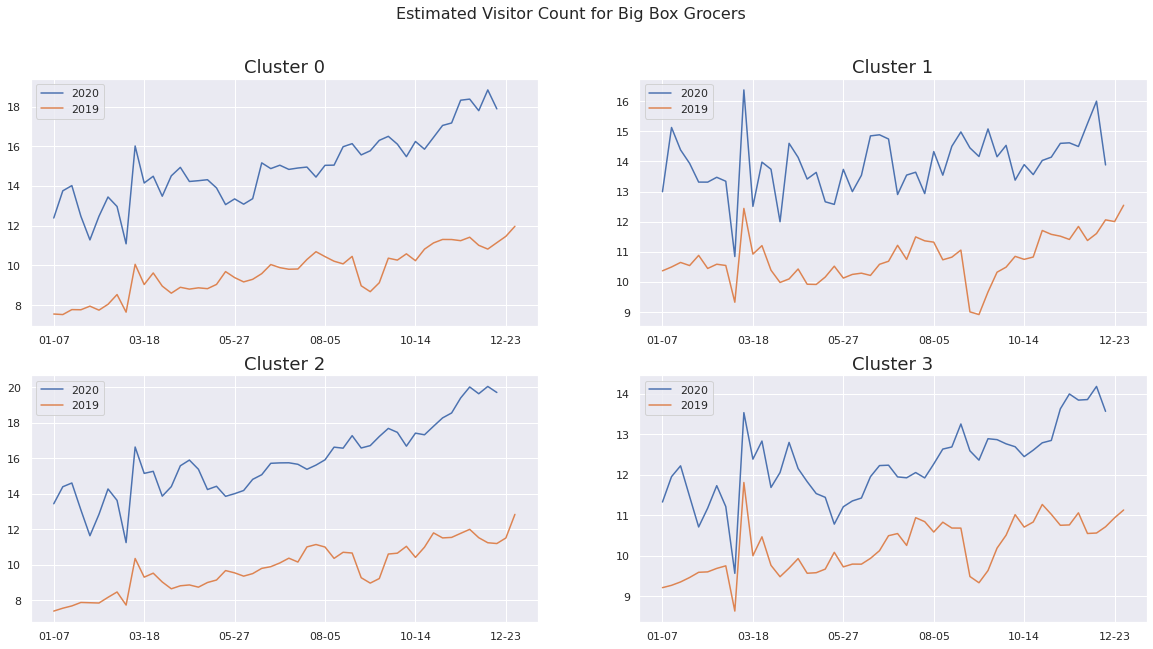

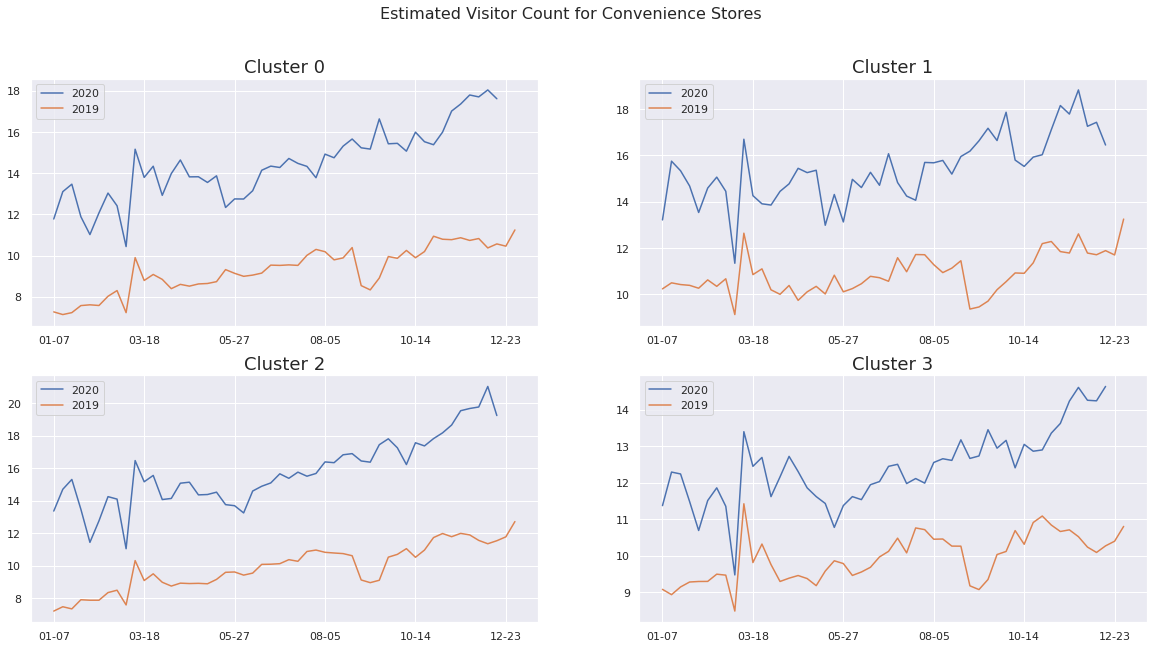

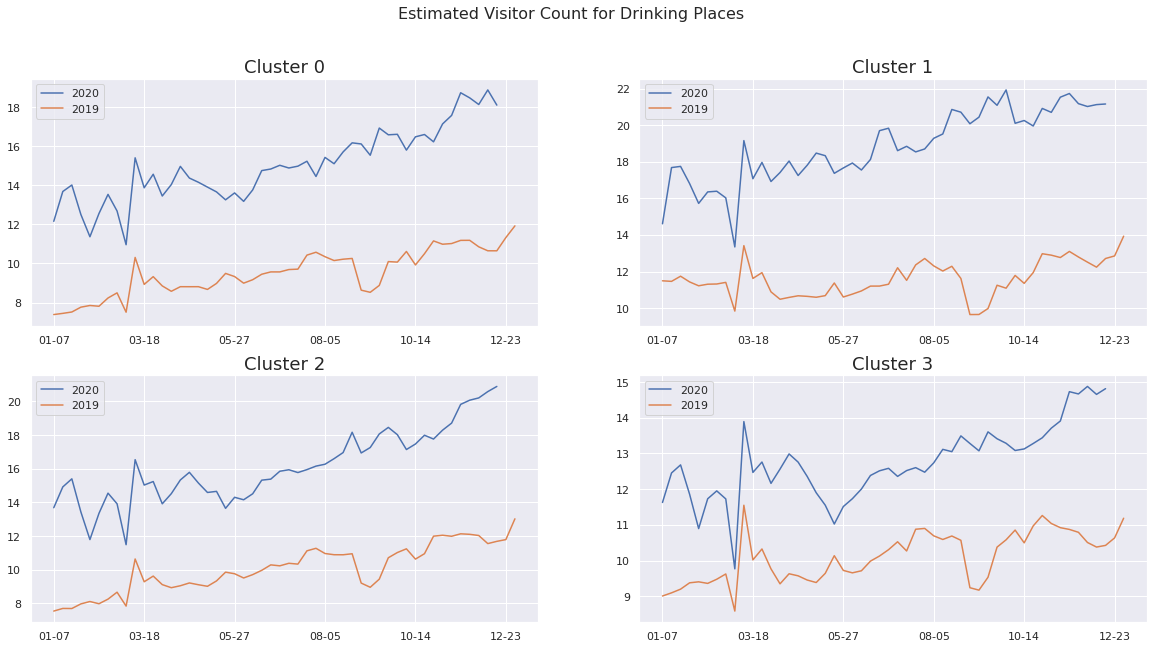

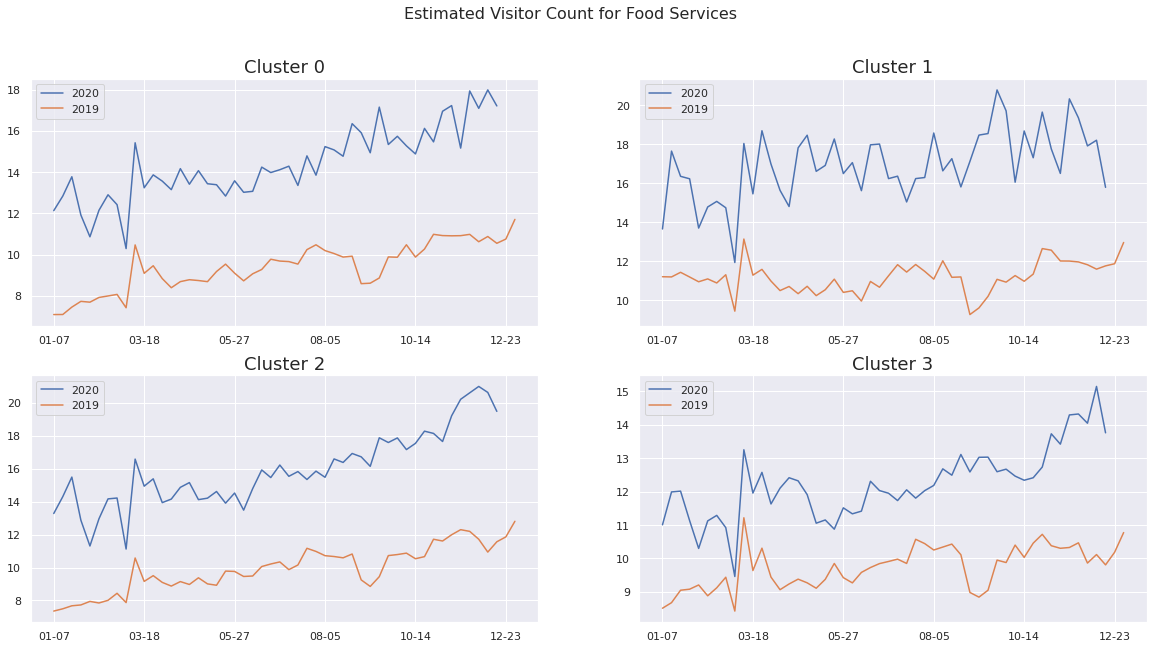

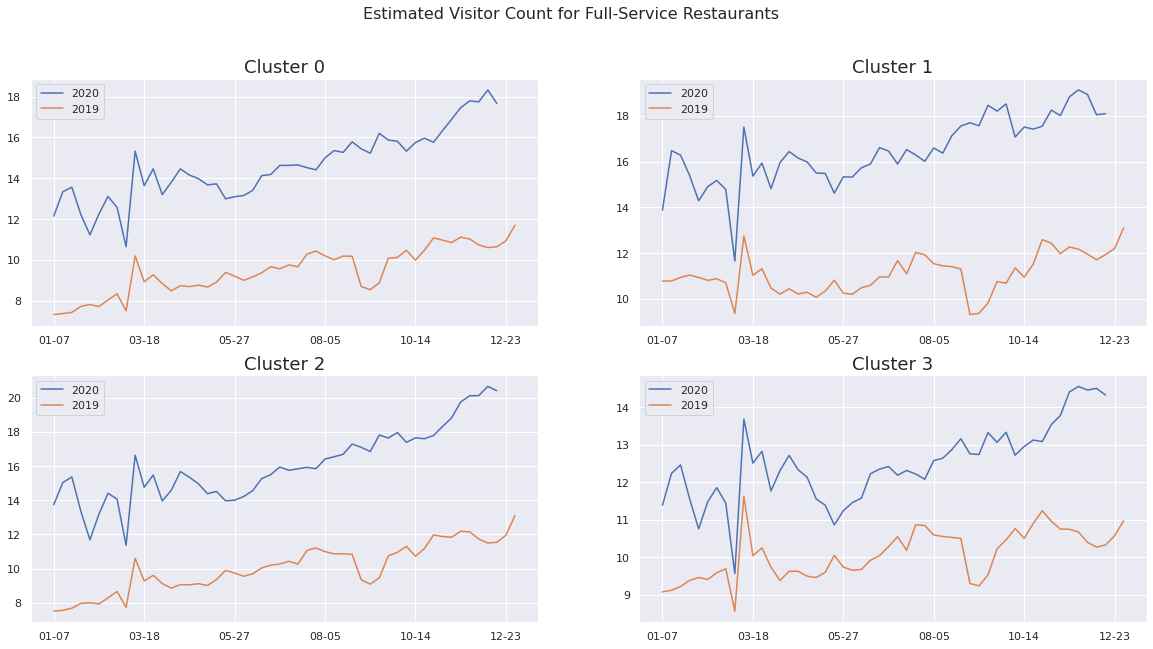

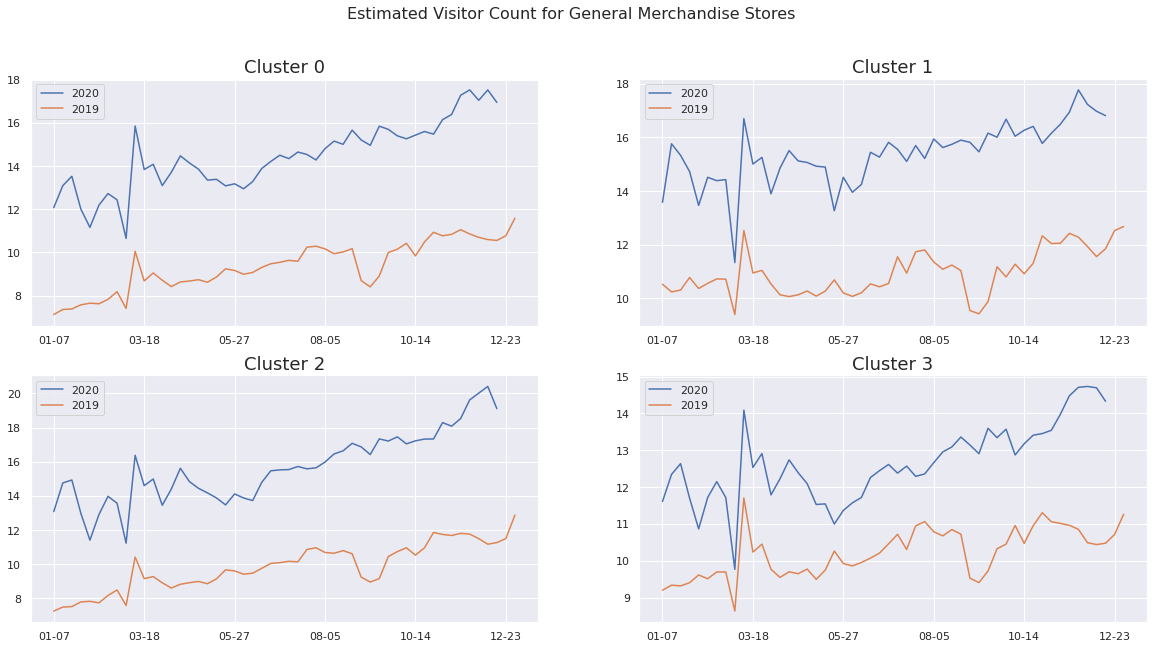

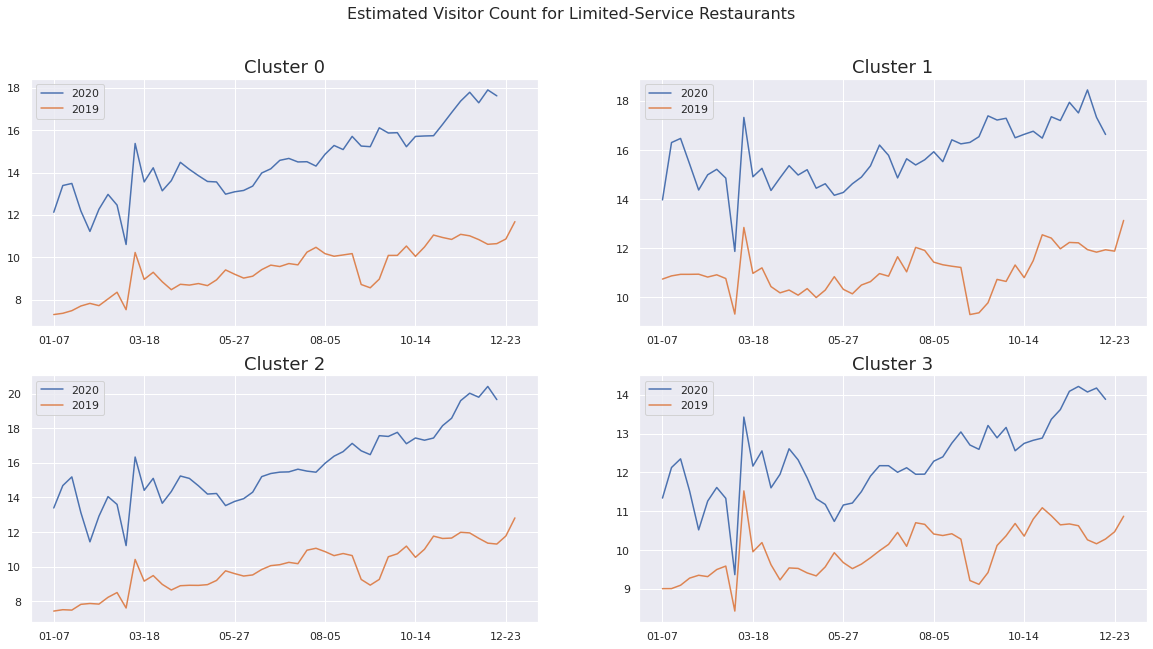

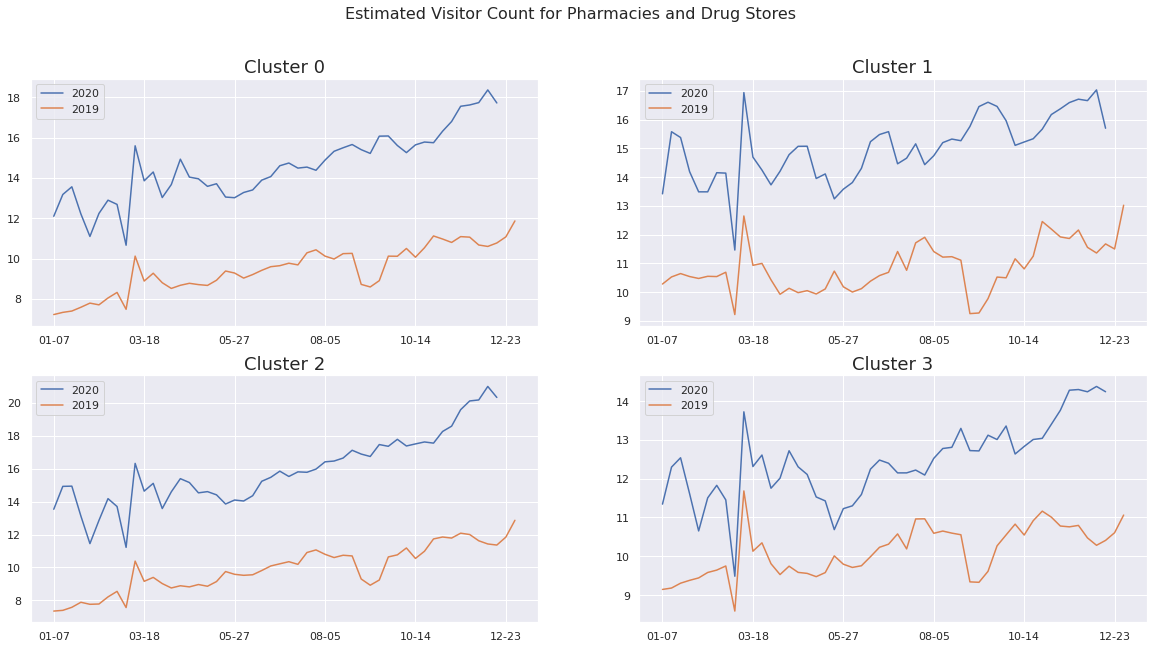

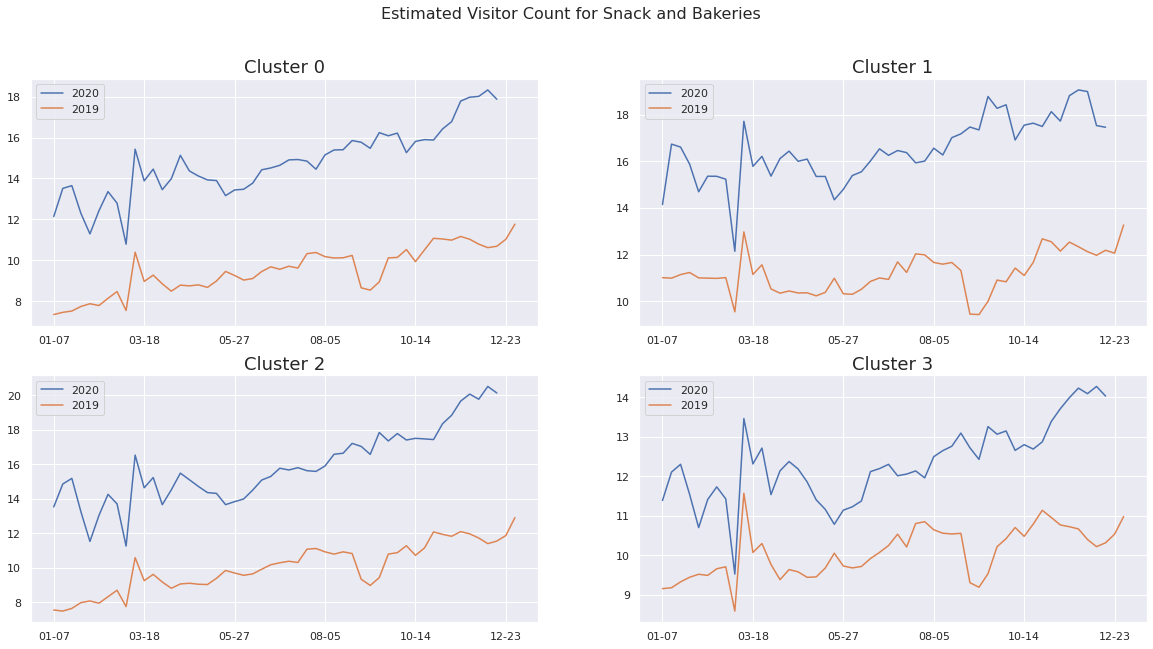

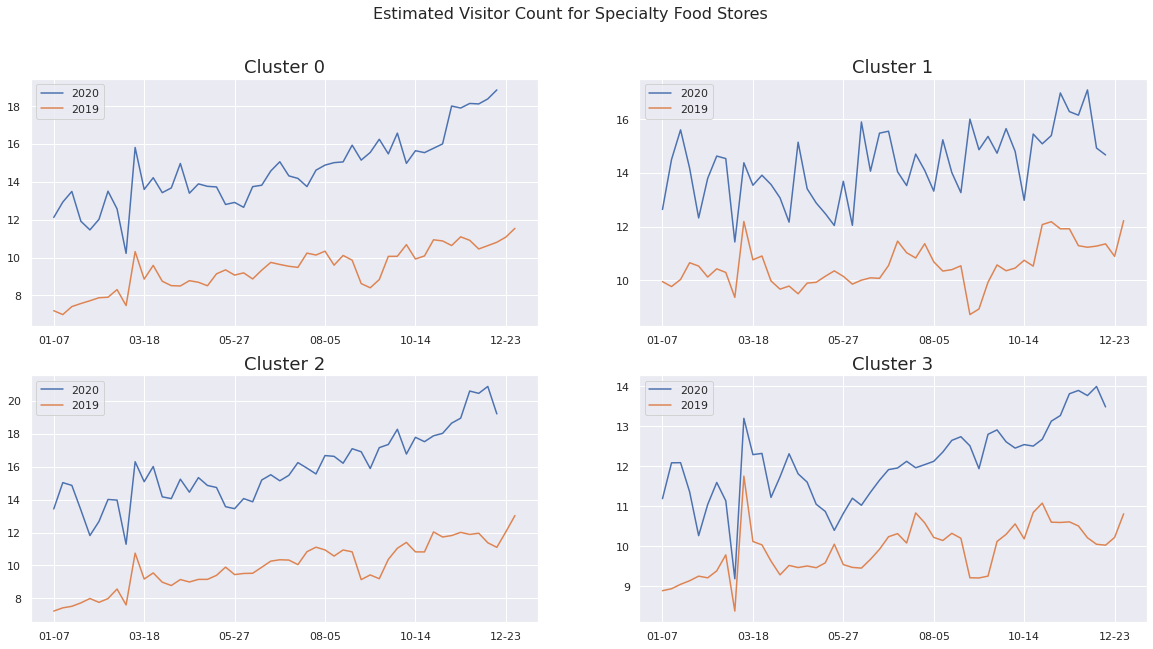

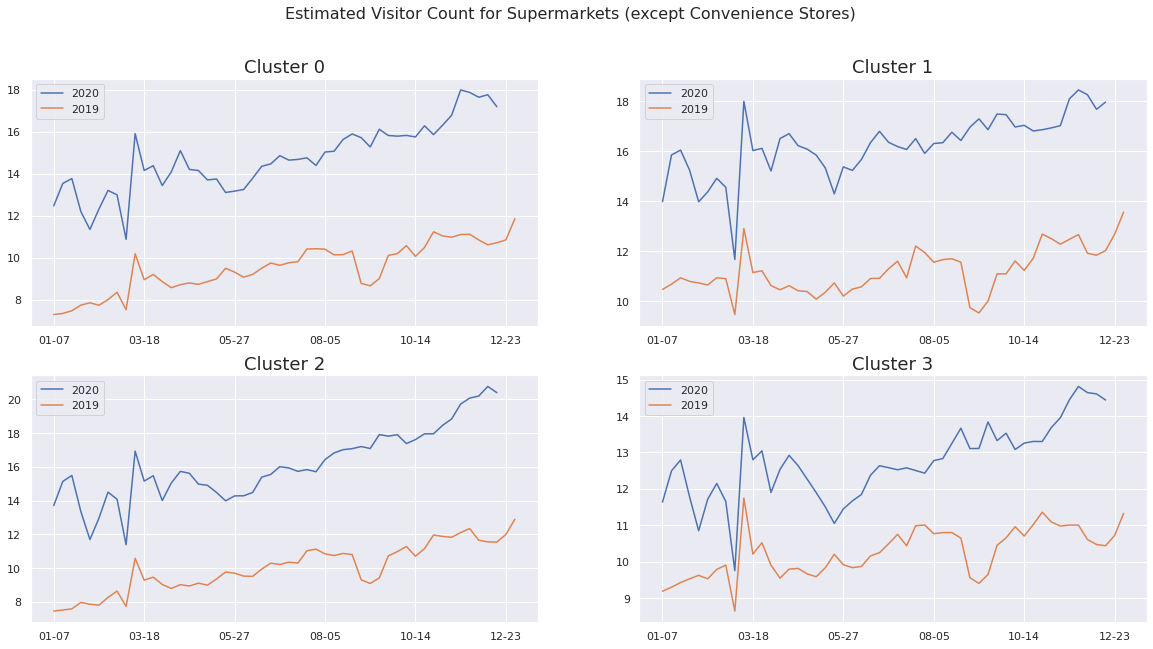

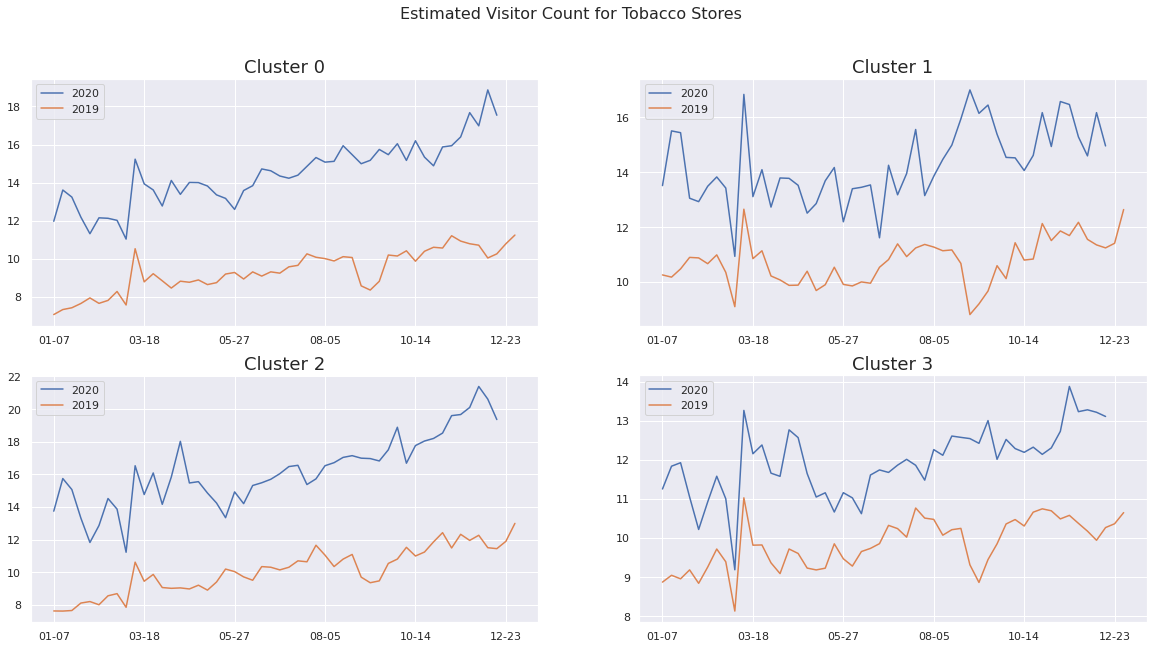

In [252]:
for n, i in enumerate(tp20.columns):
    if (n-1)//4 != n//4:
        fig, axes = plt.subplots(2,2,figsize=(20,10))
        fig.suptitle('Estimated Visitor Count for %s' % i[0], fontsize=16)
        ax = axes.ravel()
    cl = n%4
    tp20[i].plot(ax=ax[cl], label='2020', legend=True)
    tp19[i].plot(ax=ax[cl], label='2019', legend=True)
    ax[cl].set(xlabel=None, title='Cluster %d' % cl)